# Long Short-Term Memory (LSTM) model

In [1]:
!pip install --user keras-rectified-adam

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import sys
sys.path.insert(0, './utils/')
from utils import Experiment

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, TimeDistributed, Reshape, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import BatchNormalization, LSTM, Bidirectional, Conv1D, Permute, CuDNNLSTM, Activation
import tensorflow.keras.optimizers as optimizers
from keras_radam.training import RAdamOptimizer

def get_lstm_model(input_shape, lr=5e-6):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m = Dropout(0.05)(m)
    m = Permute((2, 1))(m)
    m = CuDNNLSTM(50)(m)
    m = Activation('relu')(m)
    m = Dense(500, activation='relu')(m)
    m = Dense(200, activation='relu')(m)
    m = Dense(1, activation='relu')(m)
    
    model = Model(inputs=[i], outputs=[m])

    optimizer=RAdamOptimizer(learning_rate=lr)
    model.compile(optimizer, 'mae')
    return model

Using TensorFlow backend.


# Autoregression

Normalizing Features!
(?, 23, 170)


W1002 18:04:53.112499 140662202898240 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Training...


W1002 18:04:54.042833 140662202898240 deprecation.py:323] From /.local/lib/python3.6/site-packages/keras_radam/training.py:171: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Elapsed Time: 538.7677321434021


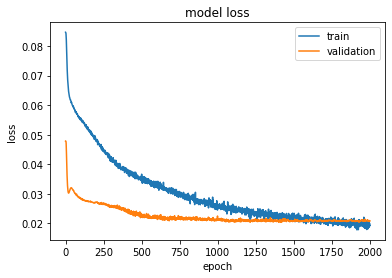

Train MAE: 7.379553087354903


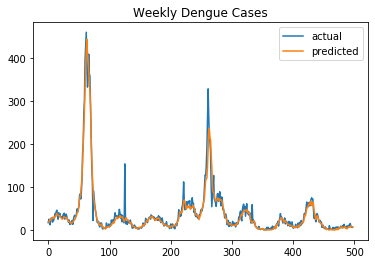

Validation MAE: 9.622747525433773


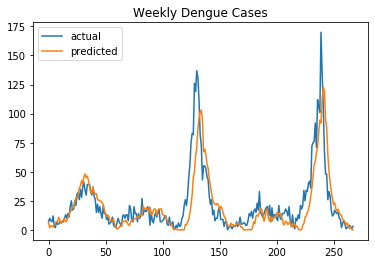

Forecast MAE: 13.75639788128102


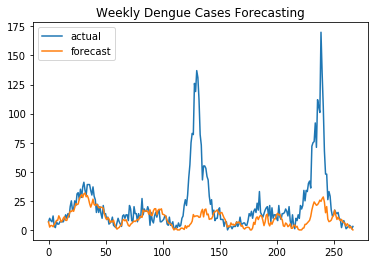

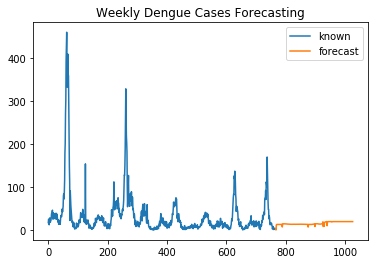

(7.379553087354903, 9.622747525433773, 13.75639788128102)


In [4]:
hyperparameters = {
    'train_split_percent': 0.65,
    'lookback_window': 170,
    'plot':True,
    'normalize': True,
    'epochs': 2000,
    'verbose':False,
    'lr':5e-6,
    'city':'sj',
}
experiment_sj_1 = Experiment(get_lstm_model, hyperparameters)
stats_df_1, df_sj_1 = experiment_sj_1.run()
print(stats_df_1)

Normalizing Features!
(?, 23, 170)
Training...
Train on 228 samples, validate on 122 samples
Epoch 1/2000
228/228 - 1s - loss: 0.0672 - val_loss: 0.0652
Epoch 2/2000
228/228 - 0s - loss: 0.0674 - val_loss: 0.0651
Epoch 3/2000
228/228 - 0s - loss: 0.0670 - val_loss: 0.0650
Epoch 4/2000
228/228 - 0s - loss: 0.0668 - val_loss: 0.0649
Epoch 5/2000
228/228 - 0s - loss: 0.0659 - val_loss: 0.0647
Epoch 6/2000
228/228 - 0s - loss: 0.0659 - val_loss: 0.0645
Epoch 7/2000
228/228 - 0s - loss: 0.0655 - val_loss: 0.0643
Epoch 8/2000
228/228 - 0s - loss: 0.0647 - val_loss: 0.0640
Epoch 9/2000
228/228 - 0s - loss: 0.0651 - val_loss: 0.0638
Epoch 10/2000
228/228 - 0s - loss: 0.0648 - val_loss: 0.0636
Epoch 11/2000
228/228 - 0s - loss: 0.0637 - val_loss: 0.0633
Epoch 12/2000
228/228 - 0s - loss: 0.0634 - val_loss: 0.0631
Epoch 13/2000
228/228 - 0s - loss: 0.0629 - val_loss: 0.0629
Epoch 14/2000
228/228 - 0s - loss: 0.0623 - val_loss: 0.0627
Epoch 15/2000
228/228 - 0s - loss: 0.0620 - val_loss: 0.0625
E

Epoch 134/2000
228/228 - 0s - loss: 0.0490 - val_loss: 0.0609
Epoch 135/2000
228/228 - 0s - loss: 0.0486 - val_loss: 0.0608
Epoch 136/2000
228/228 - 0s - loss: 0.0491 - val_loss: 0.0608
Epoch 137/2000
228/228 - 0s - loss: 0.0483 - val_loss: 0.0607
Epoch 138/2000
228/228 - 0s - loss: 0.0483 - val_loss: 0.0607
Epoch 139/2000
228/228 - 0s - loss: 0.0484 - val_loss: 0.0606
Epoch 140/2000
228/228 - 0s - loss: 0.0483 - val_loss: 0.0606
Epoch 141/2000
228/228 - 0s - loss: 0.0486 - val_loss: 0.0605
Epoch 142/2000
228/228 - 0s - loss: 0.0489 - val_loss: 0.0604
Epoch 143/2000
228/228 - 0s - loss: 0.0487 - val_loss: 0.0603
Epoch 144/2000
228/228 - 0s - loss: 0.0487 - val_loss: 0.0603
Epoch 145/2000
228/228 - 0s - loss: 0.0482 - val_loss: 0.0603
Epoch 146/2000
228/228 - 0s - loss: 0.0485 - val_loss: 0.0602
Epoch 147/2000
228/228 - 0s - loss: 0.0483 - val_loss: 0.0602
Epoch 148/2000
228/228 - 0s - loss: 0.0487 - val_loss: 0.0602
Epoch 149/2000
228/228 - 0s - loss: 0.0484 - val_loss: 0.0602
Epoch 15

228/228 - 0s - loss: 0.0469 - val_loss: 0.0582
Epoch 267/2000
228/228 - 0s - loss: 0.0469 - val_loss: 0.0582
Epoch 268/2000
228/228 - 0s - loss: 0.0467 - val_loss: 0.0582
Epoch 269/2000
228/228 - 0s - loss: 0.0472 - val_loss: 0.0582
Epoch 270/2000
228/228 - 0s - loss: 0.0472 - val_loss: 0.0581
Epoch 271/2000
228/228 - 0s - loss: 0.0466 - val_loss: 0.0581
Epoch 272/2000
228/228 - 0s - loss: 0.0467 - val_loss: 0.0581
Epoch 273/2000
228/228 - 0s - loss: 0.0469 - val_loss: 0.0581
Epoch 274/2000
228/228 - 0s - loss: 0.0465 - val_loss: 0.0581
Epoch 275/2000
228/228 - 0s - loss: 0.0474 - val_loss: 0.0581
Epoch 276/2000
228/228 - 0s - loss: 0.0469 - val_loss: 0.0581
Epoch 277/2000
228/228 - 0s - loss: 0.0469 - val_loss: 0.0580
Epoch 278/2000
228/228 - 0s - loss: 0.0470 - val_loss: 0.0580
Epoch 279/2000
228/228 - 0s - loss: 0.0471 - val_loss: 0.0580
Epoch 280/2000
228/228 - 0s - loss: 0.0467 - val_loss: 0.0579
Epoch 281/2000
228/228 - 0s - loss: 0.0472 - val_loss: 0.0579
Epoch 282/2000
228/228 

Epoch 399/2000
228/228 - 0s - loss: 0.0458 - val_loss: 0.0568
Epoch 400/2000
228/228 - 0s - loss: 0.0456 - val_loss: 0.0568
Epoch 401/2000
228/228 - 0s - loss: 0.0461 - val_loss: 0.0567
Epoch 402/2000
228/228 - 0s - loss: 0.0458 - val_loss: 0.0567
Epoch 403/2000
228/228 - 0s - loss: 0.0457 - val_loss: 0.0567
Epoch 404/2000
228/228 - 0s - loss: 0.0460 - val_loss: 0.0567
Epoch 405/2000
228/228 - 0s - loss: 0.0461 - val_loss: 0.0567
Epoch 406/2000
228/228 - 0s - loss: 0.0456 - val_loss: 0.0568
Epoch 407/2000
228/228 - 0s - loss: 0.0457 - val_loss: 0.0568
Epoch 408/2000
228/228 - 0s - loss: 0.0459 - val_loss: 0.0568
Epoch 409/2000
228/228 - 0s - loss: 0.0457 - val_loss: 0.0567
Epoch 410/2000
228/228 - 0s - loss: 0.0458 - val_loss: 0.0567
Epoch 411/2000
228/228 - 0s - loss: 0.0460 - val_loss: 0.0567
Epoch 412/2000
228/228 - 0s - loss: 0.0457 - val_loss: 0.0566
Epoch 413/2000
228/228 - 0s - loss: 0.0457 - val_loss: 0.0566
Epoch 414/2000
228/228 - 0s - loss: 0.0458 - val_loss: 0.0567
Epoch 41

228/228 - 0s - loss: 0.0442 - val_loss: 0.0559
Epoch 532/2000
228/228 - 0s - loss: 0.0443 - val_loss: 0.0559
Epoch 533/2000
228/228 - 0s - loss: 0.0449 - val_loss: 0.0559
Epoch 534/2000
228/228 - 0s - loss: 0.0444 - val_loss: 0.0559
Epoch 535/2000
228/228 - 0s - loss: 0.0446 - val_loss: 0.0559
Epoch 536/2000
228/228 - 0s - loss: 0.0449 - val_loss: 0.0559
Epoch 537/2000
228/228 - 0s - loss: 0.0442 - val_loss: 0.0559
Epoch 538/2000
228/228 - 0s - loss: 0.0450 - val_loss: 0.0559
Epoch 539/2000
228/228 - 0s - loss: 0.0448 - val_loss: 0.0559
Epoch 540/2000
228/228 - 0s - loss: 0.0450 - val_loss: 0.0559
Epoch 541/2000
228/228 - 0s - loss: 0.0446 - val_loss: 0.0558
Epoch 542/2000
228/228 - 0s - loss: 0.0444 - val_loss: 0.0559
Epoch 543/2000
228/228 - 0s - loss: 0.0446 - val_loss: 0.0559
Epoch 544/2000
228/228 - 0s - loss: 0.0450 - val_loss: 0.0559
Epoch 545/2000
228/228 - 0s - loss: 0.0447 - val_loss: 0.0559
Epoch 546/2000
228/228 - 0s - loss: 0.0443 - val_loss: 0.0558
Epoch 547/2000
228/228 

Epoch 664/2000
228/228 - 0s - loss: 0.0442 - val_loss: 0.0548
Epoch 665/2000
228/228 - 0s - loss: 0.0439 - val_loss: 0.0548
Epoch 666/2000
228/228 - 0s - loss: 0.0433 - val_loss: 0.0548
Epoch 667/2000
228/228 - 0s - loss: 0.0439 - val_loss: 0.0548
Epoch 668/2000
228/228 - 0s - loss: 0.0438 - val_loss: 0.0548
Epoch 669/2000
228/228 - 0s - loss: 0.0430 - val_loss: 0.0548
Epoch 670/2000
228/228 - 0s - loss: 0.0431 - val_loss: 0.0548
Epoch 671/2000
228/228 - 0s - loss: 0.0441 - val_loss: 0.0549
Epoch 672/2000
228/228 - 0s - loss: 0.0434 - val_loss: 0.0549
Epoch 673/2000
228/228 - 0s - loss: 0.0438 - val_loss: 0.0548
Epoch 674/2000
228/228 - 0s - loss: 0.0437 - val_loss: 0.0547
Epoch 675/2000
228/228 - 0s - loss: 0.0431 - val_loss: 0.0547
Epoch 676/2000
228/228 - 0s - loss: 0.0440 - val_loss: 0.0547
Epoch 677/2000
228/228 - 0s - loss: 0.0438 - val_loss: 0.0547
Epoch 678/2000
228/228 - 0s - loss: 0.0433 - val_loss: 0.0547
Epoch 679/2000
228/228 - 0s - loss: 0.0434 - val_loss: 0.0547
Epoch 68

228/228 - 0s - loss: 0.0421 - val_loss: 0.0542
Epoch 797/2000
228/228 - 0s - loss: 0.0430 - val_loss: 0.0542
Epoch 798/2000
228/228 - 0s - loss: 0.0430 - val_loss: 0.0542
Epoch 799/2000
228/228 - 0s - loss: 0.0430 - val_loss: 0.0542
Epoch 800/2000
228/228 - 0s - loss: 0.0426 - val_loss: 0.0542
Epoch 801/2000
228/228 - 0s - loss: 0.0433 - val_loss: 0.0543
Epoch 802/2000
228/228 - 0s - loss: 0.0432 - val_loss: 0.0543
Epoch 803/2000
228/228 - 0s - loss: 0.0431 - val_loss: 0.0543
Epoch 804/2000
228/228 - 0s - loss: 0.0427 - val_loss: 0.0542
Epoch 805/2000
228/228 - 0s - loss: 0.0434 - val_loss: 0.0542
Epoch 806/2000
228/228 - 0s - loss: 0.0424 - val_loss: 0.0542
Epoch 807/2000
228/228 - 0s - loss: 0.0431 - val_loss: 0.0542
Epoch 808/2000
228/228 - 0s - loss: 0.0425 - val_loss: 0.0542
Epoch 809/2000
228/228 - 0s - loss: 0.0428 - val_loss: 0.0542
Epoch 810/2000
228/228 - 0s - loss: 0.0428 - val_loss: 0.0542
Epoch 811/2000
228/228 - 0s - loss: 0.0433 - val_loss: 0.0542
Epoch 812/2000
228/228 

Epoch 929/2000
228/228 - 0s - loss: 0.0428 - val_loss: 0.0541
Epoch 930/2000
228/228 - 0s - loss: 0.0426 - val_loss: 0.0541
Epoch 931/2000
228/228 - 0s - loss: 0.0419 - val_loss: 0.0541
Epoch 932/2000
228/228 - 0s - loss: 0.0421 - val_loss: 0.0542
Epoch 933/2000
228/228 - 0s - loss: 0.0424 - val_loss: 0.0542
Epoch 934/2000
228/228 - 0s - loss: 0.0417 - val_loss: 0.0542
Epoch 935/2000
228/228 - 0s - loss: 0.0414 - val_loss: 0.0541
Epoch 936/2000
228/228 - 0s - loss: 0.0424 - val_loss: 0.0541
Epoch 937/2000
228/228 - 0s - loss: 0.0423 - val_loss: 0.0541
Epoch 938/2000
228/228 - 0s - loss: 0.0420 - val_loss: 0.0541
Epoch 939/2000
228/228 - 0s - loss: 0.0427 - val_loss: 0.0541
Epoch 940/2000
228/228 - 0s - loss: 0.0420 - val_loss: 0.0541
Epoch 941/2000
228/228 - 0s - loss: 0.0418 - val_loss: 0.0541
Epoch 942/2000
228/228 - 0s - loss: 0.0413 - val_loss: 0.0541
Epoch 943/2000
228/228 - 0s - loss: 0.0419 - val_loss: 0.0541
Epoch 944/2000
228/228 - 0s - loss: 0.0424 - val_loss: 0.0541
Epoch 94

228/228 - 0s - loss: 0.0416 - val_loss: 0.0540
Epoch 1061/2000
228/228 - 0s - loss: 0.0416 - val_loss: 0.0539
Epoch 1062/2000
228/228 - 0s - loss: 0.0414 - val_loss: 0.0539
Epoch 1063/2000
228/228 - 0s - loss: 0.0416 - val_loss: 0.0540
Epoch 1064/2000
228/228 - 0s - loss: 0.0420 - val_loss: 0.0540
Epoch 1065/2000
228/228 - 0s - loss: 0.0414 - val_loss: 0.0541
Epoch 1066/2000
228/228 - 0s - loss: 0.0408 - val_loss: 0.0541
Epoch 1067/2000
228/228 - 0s - loss: 0.0418 - val_loss: 0.0540
Epoch 1068/2000
228/228 - 0s - loss: 0.0414 - val_loss: 0.0540
Epoch 1069/2000
228/228 - 0s - loss: 0.0418 - val_loss: 0.0539
Epoch 1070/2000
228/228 - 0s - loss: 0.0412 - val_loss: 0.0539
Epoch 1071/2000
228/228 - 0s - loss: 0.0411 - val_loss: 0.0540
Epoch 1072/2000
228/228 - 0s - loss: 0.0414 - val_loss: 0.0540
Epoch 1073/2000
228/228 - 0s - loss: 0.0409 - val_loss: 0.0540
Epoch 1074/2000
228/228 - 0s - loss: 0.0413 - val_loss: 0.0539
Epoch 1075/2000
228/228 - 0s - loss: 0.0411 - val_loss: 0.0539
Epoch 10

Epoch 1191/2000
228/228 - 0s - loss: 0.0410 - val_loss: 0.0539
Epoch 1192/2000
228/228 - 0s - loss: 0.0411 - val_loss: 0.0539
Epoch 1193/2000
228/228 - 0s - loss: 0.0404 - val_loss: 0.0539
Epoch 1194/2000
228/228 - 0s - loss: 0.0402 - val_loss: 0.0539
Epoch 1195/2000
228/228 - 0s - loss: 0.0406 - val_loss: 0.0539
Epoch 1196/2000
228/228 - 0s - loss: 0.0402 - val_loss: 0.0539
Epoch 1197/2000
228/228 - 0s - loss: 0.0407 - val_loss: 0.0539
Epoch 1198/2000
228/228 - 0s - loss: 0.0407 - val_loss: 0.0540
Epoch 1199/2000
228/228 - 0s - loss: 0.0413 - val_loss: 0.0540
Epoch 1200/2000
228/228 - 0s - loss: 0.0410 - val_loss: 0.0540
Epoch 1201/2000
228/228 - 0s - loss: 0.0410 - val_loss: 0.0539
Epoch 1202/2000
228/228 - 0s - loss: 0.0421 - val_loss: 0.0539
Epoch 1203/2000
228/228 - 0s - loss: 0.0401 - val_loss: 0.0540
Epoch 1204/2000
228/228 - 0s - loss: 0.0399 - val_loss: 0.0539
Epoch 1205/2000
228/228 - 0s - loss: 0.0410 - val_loss: 0.0539
Epoch 1206/2000
228/228 - 0s - loss: 0.0411 - val_loss:

228/228 - 0s - loss: 0.0405 - val_loss: 0.0539
Epoch 1322/2000
228/228 - 0s - loss: 0.0395 - val_loss: 0.0539
Epoch 1323/2000
228/228 - 0s - loss: 0.0404 - val_loss: 0.0540
Epoch 1324/2000
228/228 - 0s - loss: 0.0399 - val_loss: 0.0540
Epoch 1325/2000
228/228 - 0s - loss: 0.0400 - val_loss: 0.0539
Epoch 1326/2000
228/228 - 0s - loss: 0.0402 - val_loss: 0.0539
Epoch 1327/2000
228/228 - 0s - loss: 0.0395 - val_loss: 0.0539
Epoch 1328/2000
228/228 - 0s - loss: 0.0404 - val_loss: 0.0539
Epoch 1329/2000
228/228 - 0s - loss: 0.0408 - val_loss: 0.0540
Epoch 1330/2000
228/228 - 0s - loss: 0.0405 - val_loss: 0.0540
Epoch 1331/2000
228/228 - 0s - loss: 0.0396 - val_loss: 0.0540
Epoch 1332/2000
228/228 - 0s - loss: 0.0410 - val_loss: 0.0540
Epoch 1333/2000
228/228 - 0s - loss: 0.0401 - val_loss: 0.0540
Epoch 1334/2000
228/228 - 0s - loss: 0.0412 - val_loss: 0.0539
Epoch 1335/2000
228/228 - 0s - loss: 0.0407 - val_loss: 0.0540
Epoch 1336/2000
228/228 - 0s - loss: 0.0397 - val_loss: 0.0540
Epoch 13

Epoch 1452/2000
228/228 - 0s - loss: 0.0398 - val_loss: 0.0537
Epoch 1453/2000
228/228 - 0s - loss: 0.0399 - val_loss: 0.0538
Epoch 1454/2000
228/228 - 0s - loss: 0.0400 - val_loss: 0.0538
Epoch 1455/2000
228/228 - 0s - loss: 0.0399 - val_loss: 0.0538
Epoch 1456/2000
228/228 - 0s - loss: 0.0393 - val_loss: 0.0538
Epoch 1457/2000
228/228 - 0s - loss: 0.0395 - val_loss: 0.0538
Epoch 1458/2000
228/228 - 0s - loss: 0.0390 - val_loss: 0.0538
Epoch 1459/2000
228/228 - 0s - loss: 0.0391 - val_loss: 0.0538
Epoch 1460/2000
228/228 - 0s - loss: 0.0401 - val_loss: 0.0538
Epoch 1461/2000
228/228 - 0s - loss: 0.0389 - val_loss: 0.0538
Epoch 1462/2000
228/228 - 0s - loss: 0.0402 - val_loss: 0.0538
Epoch 1463/2000
228/228 - 0s - loss: 0.0399 - val_loss: 0.0539
Epoch 1464/2000
228/228 - 0s - loss: 0.0409 - val_loss: 0.0538
Epoch 1465/2000
228/228 - 0s - loss: 0.0397 - val_loss: 0.0538
Epoch 1466/2000
228/228 - 0s - loss: 0.0392 - val_loss: 0.0537
Epoch 1467/2000
228/228 - 0s - loss: 0.0396 - val_loss:

228/228 - 0s - loss: 0.0395 - val_loss: 0.0535
Epoch 1583/2000
228/228 - 0s - loss: 0.0388 - val_loss: 0.0536
Epoch 1584/2000
228/228 - 0s - loss: 0.0395 - val_loss: 0.0537
Epoch 1585/2000
228/228 - 0s - loss: 0.0403 - val_loss: 0.0537
Epoch 1586/2000
228/228 - 0s - loss: 0.0393 - val_loss: 0.0537
Epoch 1587/2000
228/228 - 0s - loss: 0.0398 - val_loss: 0.0535
Epoch 1588/2000
228/228 - 0s - loss: 0.0394 - val_loss: 0.0534
Epoch 1589/2000
228/228 - 0s - loss: 0.0398 - val_loss: 0.0535
Epoch 1590/2000
228/228 - 0s - loss: 0.0389 - val_loss: 0.0536
Epoch 1591/2000
228/228 - 0s - loss: 0.0393 - val_loss: 0.0536
Epoch 1592/2000
228/228 - 0s - loss: 0.0393 - val_loss: 0.0536
Epoch 1593/2000
228/228 - 0s - loss: 0.0393 - val_loss: 0.0536
Epoch 1594/2000
228/228 - 0s - loss: 0.0387 - val_loss: 0.0536
Epoch 1595/2000
228/228 - 0s - loss: 0.0387 - val_loss: 0.0535
Epoch 1596/2000
228/228 - 0s - loss: 0.0385 - val_loss: 0.0534
Epoch 1597/2000
228/228 - 0s - loss: 0.0393 - val_loss: 0.0534
Epoch 15

Epoch 1713/2000
228/228 - 0s - loss: 0.0378 - val_loss: 0.0533
Epoch 1714/2000
228/228 - 0s - loss: 0.0403 - val_loss: 0.0533
Epoch 1715/2000
228/228 - 0s - loss: 0.0391 - val_loss: 0.0534
Epoch 1716/2000
228/228 - 0s - loss: 0.0385 - val_loss: 0.0535
Epoch 1717/2000
228/228 - 0s - loss: 0.0391 - val_loss: 0.0536
Epoch 1718/2000
228/228 - 0s - loss: 0.0388 - val_loss: 0.0536
Epoch 1719/2000
228/228 - 0s - loss: 0.0387 - val_loss: 0.0533
Epoch 1720/2000
228/228 - 0s - loss: 0.0396 - val_loss: 0.0532
Epoch 1721/2000
228/228 - 0s - loss: 0.0398 - val_loss: 0.0532
Epoch 1722/2000
228/228 - 0s - loss: 0.0392 - val_loss: 0.0533
Epoch 1723/2000
228/228 - 0s - loss: 0.0391 - val_loss: 0.0534
Epoch 1724/2000
228/228 - 0s - loss: 0.0384 - val_loss: 0.0534
Epoch 1725/2000
228/228 - 0s - loss: 0.0388 - val_loss: 0.0533
Epoch 1726/2000
228/228 - 0s - loss: 0.0388 - val_loss: 0.0534
Epoch 1727/2000
228/228 - 0s - loss: 0.0390 - val_loss: 0.0534
Epoch 1728/2000
228/228 - 0s - loss: 0.0388 - val_loss:

228/228 - 0s - loss: 0.0379 - val_loss: 0.0529
Epoch 1844/2000
228/228 - 0s - loss: 0.0381 - val_loss: 0.0530
Epoch 1845/2000
228/228 - 0s - loss: 0.0371 - val_loss: 0.0530
Epoch 1846/2000
228/228 - 0s - loss: 0.0376 - val_loss: 0.0531
Epoch 1847/2000
228/228 - 0s - loss: 0.0389 - val_loss: 0.0531
Epoch 1848/2000
228/228 - 0s - loss: 0.0374 - val_loss: 0.0530
Epoch 1849/2000
228/228 - 0s - loss: 0.0380 - val_loss: 0.0529
Epoch 1850/2000
228/228 - 0s - loss: 0.0377 - val_loss: 0.0529
Epoch 1851/2000
228/228 - 0s - loss: 0.0395 - val_loss: 0.0529
Epoch 1852/2000
228/228 - 0s - loss: 0.0377 - val_loss: 0.0530
Epoch 1853/2000
228/228 - 0s - loss: 0.0367 - val_loss: 0.0531
Epoch 1854/2000
228/228 - 0s - loss: 0.0374 - val_loss: 0.0531
Epoch 1855/2000
228/228 - 0s - loss: 0.0386 - val_loss: 0.0531
Epoch 1856/2000
228/228 - 0s - loss: 0.0380 - val_loss: 0.0530
Epoch 1857/2000
228/228 - 0s - loss: 0.0389 - val_loss: 0.0529
Epoch 1858/2000
228/228 - 0s - loss: 0.0381 - val_loss: 0.0529
Epoch 18

Epoch 1974/2000
228/228 - 0s - loss: 0.0378 - val_loss: 0.0528
Epoch 1975/2000
228/228 - 0s - loss: 0.0383 - val_loss: 0.0527
Epoch 1976/2000
228/228 - 0s - loss: 0.0373 - val_loss: 0.0526
Epoch 1977/2000
228/228 - 0s - loss: 0.0372 - val_loss: 0.0527
Epoch 1978/2000
228/228 - 0s - loss: 0.0383 - val_loss: 0.0528
Epoch 1979/2000
228/228 - 0s - loss: 0.0384 - val_loss: 0.0528
Epoch 1980/2000
228/228 - 0s - loss: 0.0379 - val_loss: 0.0527
Epoch 1981/2000
228/228 - 0s - loss: 0.0381 - val_loss: 0.0527
Epoch 1982/2000
228/228 - 0s - loss: 0.0376 - val_loss: 0.0527
Epoch 1983/2000
228/228 - 0s - loss: 0.0380 - val_loss: 0.0526
Epoch 1984/2000
228/228 - 0s - loss: 0.0375 - val_loss: 0.0526
Epoch 1985/2000
228/228 - 0s - loss: 0.0379 - val_loss: 0.0526
Epoch 1986/2000
228/228 - 0s - loss: 0.0386 - val_loss: 0.0526
Epoch 1987/2000
228/228 - 0s - loss: 0.0374 - val_loss: 0.0526
Epoch 1988/2000
228/228 - 0s - loss: 0.0387 - val_loss: 0.0526
Epoch 1989/2000
228/228 - 0s - loss: 0.0383 - val_loss:

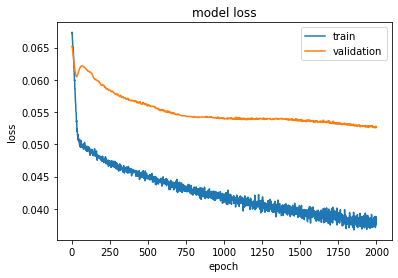

Train MAE: 4.127321139239428


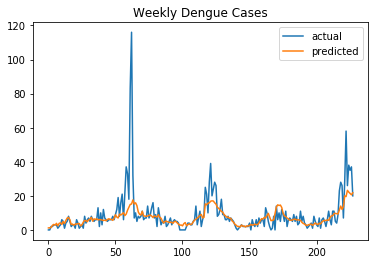

Validation MAE: 6.102955058827752


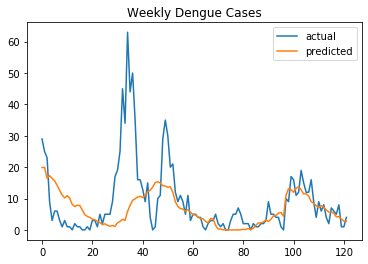

Forecast MAE: 7.9635212343247215


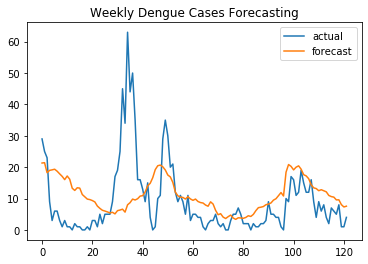

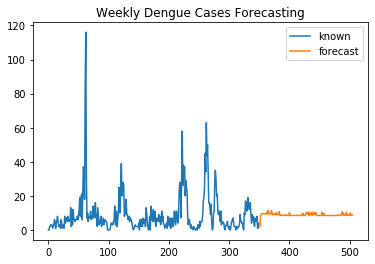

(4.127321139239428, 6.102955058827752, 7.9635212343247215)


In [10]:
hyperparameters = {
    'train_split_percent': 0.65,
    'lookback_window': 170,
    'plot':True,
    'normalize': True,
    'epochs': 2000,
    'lr': 5e-6,
    'verbose': 2,
    'city':'iq'
}
experiment_iq_1 = Experiment(get_lstm_model, hyperparameters)
stats_iq_1, df_iq_1 = experiment_iq_1.run()
print(stats_iq_1)

## Feature Regression

Normalizing Features!
(?, 22, 170)
Training...
Elapsed Time: 536.8675208091736


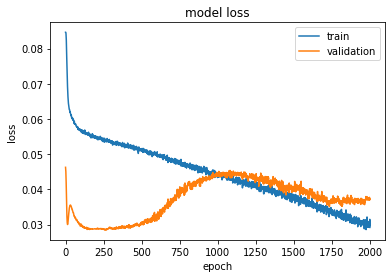

Train MAE: 11.237902156200754


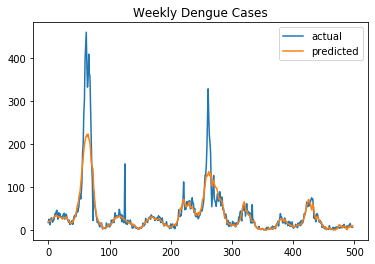

Validation MAE: 17.18430881049317


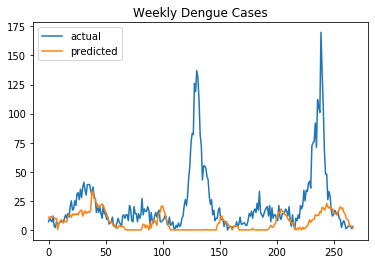

Forecast MAE: 13.008282300251633


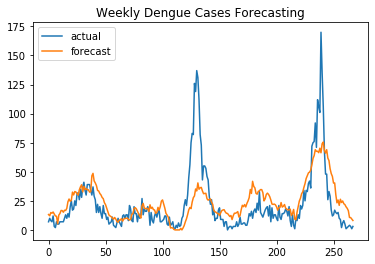

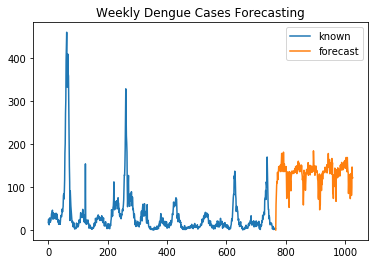

(11.237902156200754, 17.18430881049317, 13.008282300251633)


In [11]:
hyperparameters = {
    'train_split_percent': 0.65,
    'lookback_window': 170,
    'plot':True,
    'normalize': True,
    'epochs': 2000,
    'lr': 5e-6,
    'verbose':False,
    'only_features':True,
    'city':'sj',
}
experiment_sj_2 = Experiment(get_lstm_model, hyperparameters)
stats_df_2, df_sj_2 = experiment_sj_2.run()
print(stats_df_2)

Normalizing Features!
(?, 22, 170)
Training...
Elapsed Time: 264.2556474208832


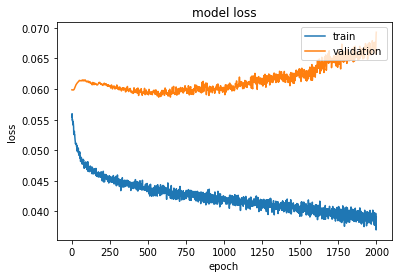

Train MAE: 4.222464343957734


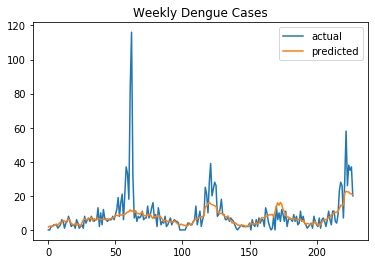

Validation MAE: 8.03731074294106


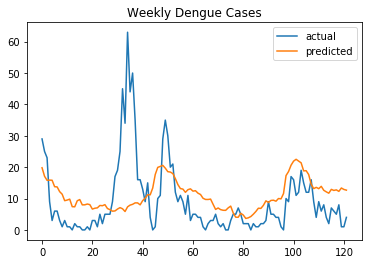

Forecast MAE: 6.5204773691834


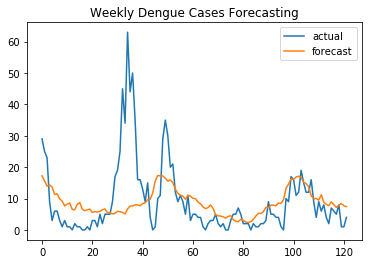

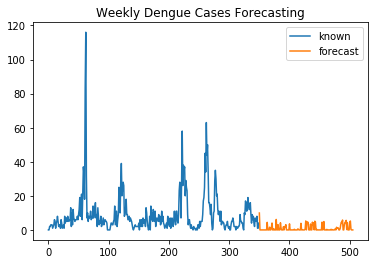

(4.222464343957734, 8.03731074294106, 6.5204773691834)


In [12]:
hyperparameters = {
    'train_split_percent': 0.65,
    'lookback_window': 170,
    'plot':True,
    'normalize': True,
    'only_features':True,
    'epochs': 2000,
    'lr': 5e-6,
    'verbose': False,
    'city':'iq'
}
experiment_iq_2 = Experiment(get_lstm_model, hyperparameters)
stats_iq_2, df_iq_2 = experiment_iq_2.run()
print(stats_iq_2)